<a href="https://colab.research.google.com/github/MattJCR/Introduccion-Whisper-tratado-correccion-analisis/blob/master/Introducci%C3%B3n_a_Whisper%2C_tratado%2C_correcci%C3%B3n_y_an%C3%A1lisis_de_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !sudo apt update && sudo apt install ffmpeg
!pip install --upgrade git+https://github.com/openai/whisper.git pytube pydub pyspellchecker collection nltk gtts diffusers==0.4.0
!nvidia-smi
!pip install pytorch-transformers scipy ftfy
!pip install "ipywidgets>=7,<8"
!pip install accelerate
# !pip install --upgrade pytube pydub pyspellchecker collection
# !pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-inj28ggp
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-inj28ggp
  Using cached diffusers-0.4.0-py3-none-any.whl (229 kB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.9.0
    Uninstalling diffusers-0.9.0:
      Successfully uninstalled diffusers-0.9.0
Tue Dec  6 16:37:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               M

In [2]:
# Import the required packages
from pytube import YouTube
# import ffmpeg
import whisper
import numpy as np
import pandas as pd
from spellchecker import SpellChecker
import re
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:

# download the video using pytube
yt = YouTube("https://www.youtube.com/watch?v=AHPrLLrCa7Y")
video = yt.streams.first().download()
video.title()

'/Content/Todo Harry Potter  Resumen En 1 Minuto.3Gpp'

In [4]:
for x in whisper.available_models(): print(x) 

tiny.en
tiny
base.en
base
small.en
small
medium.en
medium
large-v1
large-v2
large


In [5]:
# load the downloaded video using whisper
audio = whisper.load_audio(video)

# transcribe the audio using whisper's small/medium model
model = whisper.load_model("small")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} ",
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)



Model is multilingual  and has 240,582,912 parameters.


In [6]:
# load audio and pad/trim it to fit 30 seconds
audio_part = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio_part).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
language = max(probs, key=probs.get)
print(f"Detected language: {language}")

# load the spelling corrector
corrector = SpellChecker(language=language)

Detected language: es


In [7]:
result = model.transcribe(audio=audio)

In [8]:
correction_text = ''
# print the recognized text
for text in result['text'].split('.'):
  # correct the spelling of the mispelled words
  text += '.'
  correction = corrector.correction(text)
  if(correction):
    print('-'*20)
    correction_text += correction
    print('Ori:',text,'\nCor:',correction)

--------------------
Ori:  Apertencia, este vídeo contiene spoilers. 
Cor:  Apertencia, este vídeo contiene spoilers.
--------------------
Ori:  Si eres alérgico a los spoilers o crees que puede serlo, acude a tu sala de cine más cercano. 
Cor:  Si eres alérgico a los spoilers o crees que puede serlo, acude a tu sala de cine más cercano.
--------------------
Ori:  Harry Potter es un niño normal que un buen día recibe una carta para el Hogwarts. 
Cor:  Harry Potter es un niño normal que un buen día recibe una carta para el Hogwarts.
--------------------
Ori:  Y ¿qué es Hogwarts? Pues es un colegio de magia súper molol. 
Cor:  Y ¿qué es Hogwarts? Pues es un colegio de magia súper molol.
--------------------
Ori:  Tiene perros gigantes de 3 cabezas, de mentores que te absorben el alma y un enemigo mortal llamado Voldemort, que solo te ataca el último trimestre de cada curso para que haga los exámenes más tranquilos. 
Cor:  Tiene perros gigantes de 3 cabezas, de mentores que te absorben el

In [9]:
import string
def process_text(text):
    # remove punctuation and special characters
    processed_text = text.translate(str.maketrans('', '', string.punctuation + '¿¡<>'))
    # convert to lowercase
    processed_text = processed_text.lower()
    return processed_text
    
def count_most_common_words(processed_text):
    # split the text into a list of words
    words = processed_text.split()
    # create a Counter object
    word_counts = Counter(words)
    # return the most common words in descending order of frequency
    return word_counts.most_common()

In [10]:
# count the most common words
correction_text = process_text(correction_text)
most_common_words = count_most_common_words(correction_text)
# print the results
print("The most common words are:")
counter = 1
for word, count in most_common_words:
    print(f"{counter}) {word}: {count}")
    if(counter >= 5):
      break
    else:
      counter += 1

The most common words are:
1) que: 15
2) un: 11
3) a: 10
4) de: 9
5) el: 9


In [11]:
correction_text = correction_text.strip()
correction_text

'apertencia este vídeo contiene spoilers si eres alérgico a los spoilers o crees que puede serlo acude a tu sala de cine más cercano harry potter es un niño normal que un buen día recibe una carta para el hogwarts y qué es hogwarts pues es un colegio de magia súper molol tiene perros gigantes de 3 cabezas de mentores que te absorben el alma y un enemigo mortal llamado voldemort que solo te ataca el último trimestre de cada curso para que haga los exámenes más tranquilos a harry no le está yendo nada mal en el cole con 11 años se carga un profesor tartavudo con 12 lucha contra un basilisco gigante y con 13 ayuda a escapar de la justicia a un fugitivo condenado por el asesinato de 20 personas oye seguro que este chico es el bueno y que piensan sus padres a qué no tiene bueno el caso es que todo cambia en cuarto curso cuando harry descubre que voldemort ha vuelto y que ha matado a cedric dibor y no por qué ahora se convertirán un batido adolescente que brilla bajo la luz del sol pero se v

In [12]:
# Load Spanish part-of-speech tagger from nltk
nltk.download('cess_esp')
nltk.download('tagsets')
tagger = nltk.tag.UnigramTagger(nltk.corpus.cess_esp.tagged_sents())


[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [13]:
# Define a function to tag a sentence with its part-of-speech
def tag_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged_tokens = tagger.tag(tokens)
    return tagged_tokens

# Define a function to extract nouns, adjectives, and verbs from a tagged sentence
def extract_pos(tagged_sentence):
    ds = {
        'nouns':[],
        'determiners':[],
        'adjectives':[],
        'verbs':[],
        'pronoun':[],
        'adverbs':[],
        'others':[],
        'undefined': []
        }
    
    for word, pos in tagged_sentence:
      if pos != None:
        if pos.startswith('n'):
            ds['nouns'].append(word)
        elif pos.startswith('a'):
            ds['adjectives'].append(word)
        elif pos.startswith('v'):
            ds['verbs'].append(word)
        elif pos.startswith('d'):
            ds['determiners'].append(word)
        elif pos.startswith('pr'):
            ds['pronoun'].append(word)
        elif pos.startswith('adv'):
            ds['adverbs'].append(word)
        else:
          ds['others'].append(word)
      else:
        ds['undefined'].append(word)
    return ds

# create an empty list to store the categories for each token
categories = []

# Define the sentence to tag and extract POS
tagged_sentence = tag_sentence(correction_text)
data = extract_pos(tagged_sentence)


# Print the results
print(f"Nouns: {data['nouns']}")
print(f"Adjectives: {data['adjectives']}")
print(f"Verbs: {data['verbs']}")
# print(f"Others: {data.others}")

Nouns: ['vídeo', 'cine', 'niño', 'día', 'carta', 'colegio', 'magia', 'perros', 'gigantes', 'cabezas', 'alma', 'enemigo', 'trimestre', 'curso', 'años', 'carga', 'profesor', 'lucha', 'gigante', 'ayuda', 'justicia', 'asesinato', 'personas', 'chico', 'padres', 'caso', 'curso', 'luz', 'sol', 'práctica', 'chaval', 'años', 'duelo', 'condiciones', 'edad', 'colegio', 'vida', 'cursos', 'parte', 'fama', 'amigos', 'novia']
Adjectives: ['cercano', 'normal', 'buen', 'mortal', 'llamado', 'solo', 'último', 'seguro', 'bueno', 'bueno', 'cuarto', 'octavo', 'suficiente', 'viva']
Verbs: ['contiene', 'eres', 'puede', 'acude', 'es', 'recibe', 'es', 'es', 'tiene', 'haga', 'está', 'escapar', 'condenado', 'oye', 'es', 'piensan', 'tiene', 'es', 'cambia', 'descubre', 'ha', 'vuelto', 'ha', 'matado', 'convertirán', 've', 'tiene', 'convirtiendo', 'acabando', 'va', 'conseguir', 'tendrá', 'abandonar', 'ha', 'intentado', 'acabar', 'ha', 'dado', 'quiero', 'ir']


In [14]:
for x in data:
  print(x+'(' + str(len(data[x])) + '):',data[x])

nouns(42): ['vídeo', 'cine', 'niño', 'día', 'carta', 'colegio', 'magia', 'perros', 'gigantes', 'cabezas', 'alma', 'enemigo', 'trimestre', 'curso', 'años', 'carga', 'profesor', 'lucha', 'gigante', 'ayuda', 'justicia', 'asesinato', 'personas', 'chico', 'padres', 'caso', 'curso', 'luz', 'sol', 'práctica', 'chaval', 'años', 'duelo', 'condiciones', 'edad', 'colegio', 'vida', 'cursos', 'parte', 'fama', 'amigos', 'novia']
determiners(37): ['este', 'los', 'tu', 'un', 'un', 'una', 'el', 'un', 'el', 'un', 'el', 'cada', 'los', 'el', 'un', 'un', 'la', 'un', 'el', 'este', 'el', 'sus', 'el', 'todo', 'un', 'la', 'un', 'un', 'el', 'un', 'la', 'el', 'su', 'siete', 'otra', 'dos', 'una']
adjectives(14): ['cercano', 'normal', 'buen', 'mortal', 'llamado', 'solo', 'último', 'seguro', 'bueno', 'bueno', 'cuarto', 'octavo', 'suficiente', 'viva']
verbs(40): ['contiene', 'eres', 'puede', 'acude', 'es', 'recibe', 'es', 'es', 'tiene', 'haga', 'está', 'escapar', 'condenado', 'oye', 'es', 'piensan', 'tiene', 'es', '

In [15]:
import gtts
# Especifica el texto que quieres convertir a audio
text = result['text']
print('language: ',gtts.lang.tts_langs()[language])
# Crea un objeto de la clase gTTS
audio = gtts.gTTS(text=text, lang=language)
audio
# Guarda el audio en un archivo
audio.save("audio.mp3")

language:  Spanish


In [16]:
from IPython.display import Audio
# Especifica el archivo de audio que quieres reproducir
audio_file = "audio.mp3"

# Crea un objeto de la clase Audio
audio = Audio(audio_file)

# Reproduce el audio
audio

In [17]:
# Import the required packages
from diffusers import StableDiffusionPipeline
import torch
import gc
gc.collect()

# Create a StableDiffusionPipeline object and move it to a GPU
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to('cuda')

# Set the number of inference steps to use
num_inference_steps = 20

# Set the random seed for deterministic output
generator = torch.Generator("cuda").manual_seed(1)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'clip_sample': False} were passed to PNDMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['| curso | luz | sol | práctica | chaval | años | duelo | condiciones | edad | colegio | vida | cursos | parte | fama | amigos | novia | cercano | normal | buen | mortal | llamado | solo | último | seguro | bueno | bueno | cuarto | octavo | suficiente | viva | contiene | eres | puede | acude | es | recibe | es | es | tiene | haga | está | escapar | condenado | oye | es | piensan | tiene | es | cambia | descubre | ha | vuelto | ha | matado | convertirán | ve | tiene | convirtiendo | acabando | va | conseguir | tendrá | abandonar | ha | intentado | acabar | ha | dado | quiero | ir | si | a | o | a | de | más | para | y | qué | pues | de | de | 3 | de | te | y | te | de | para | más | a | no | le | nada | mal | en | con | 1 1 | se | con | 1 2 | contra | y | con | 1 3 | a | de | a | por | de | 2 0 | y | a | qué | no | en | cuando | y | a | y | no | por | qué | ahora | se | bajo | del | p

vídeo | cine | niño | día | carta | colegio | magia | perros | gigantes | cabezas | alma | enemigo | trimestre | curso | años | carga | profesor | lucha | gigante | ayuda | justicia | asesinato | personas | chico | padres | caso | curso | luz | sol | práctica | chaval | años | duelo | condiciones | edad | colegio | vida | cursos | parte | fama | amigos | novia | cercano | normal | buen | mortal | llamado | solo | último | seguro | bueno | bueno | cuarto | octavo | suficiente | viva | contiene | eres | puede | acude | es | recibe | es | es | tiene | haga | está | escapar | condenado | oye | es | piensan | tiene | es | cambia | descubre | ha | vuelto | ha | matado | convertirán | ve | tiene | convirtiendo | acabando | va | conseguir | tendrá | abandonar | ha | intentado | acabar | ha | dado | quiero | ir | si | a | o | a | de | más | para | y | qué | pues | de | de | 3 | de | te | y | te | de | para | más | a | no | le | nada | mal | en | con | 11 | se | con | 12 | contra | y | con | 13 

  0%|          | 0/21 [00:00<?, ?it/s]

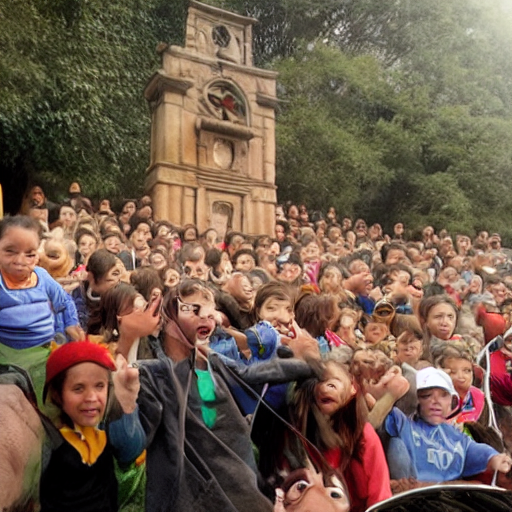

In [26]:
# Define the text prompt
prompt = ''
for x in data['nouns']:
  prompt += (x + ' | ')
for x in data['adjectives']:
  prompt += (x + ' | ')
for x in data['verbs']:
  prompt += (x + ' | ')
for x in data['others']:
  prompt += (x + ' | ')
print(prompt)
# Generate the image
# image = pipe(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]
image = pipe(prompt, num_inference_steps=num_inference_steps).images[0]
image